In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from skimage.exposure import rescale_intensity, histogram
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.measure import label, regionprops
from skimage.morphology import area_opening, opening, disk, reconstruction
from iaf.morph.watershed import separate_neighboring_objects
from iaf.color import get_labels_cmap
from iaf.plot import imshow, show_labels
from iaf.notebook import init_style
from skimage.filters import gaussian
from iaf.process import subtract_background
init_style()

In [2]:
from iaf.io.readers import NikonND2Reader

In [3]:
filename = r"/Users/youmna/Desktop/ETH/MA1/Labs/CellAnalysis/ImageAnalysis/ABBOUD_Homework/U2OS.nd2"

In [4]:
reader = NikonND2Reader(filename)
reader

NikonND2Reader("U2OS.nd2")
  - Dimensions: (v=40, t=1, c=2, z=1, y=2044, x=2048)
  - Voxel size: (x=0.3238µm, y=0.3238µm, z=0.0000µm)
  - Series geometry: "cyx"

(2, 2044, 2048)


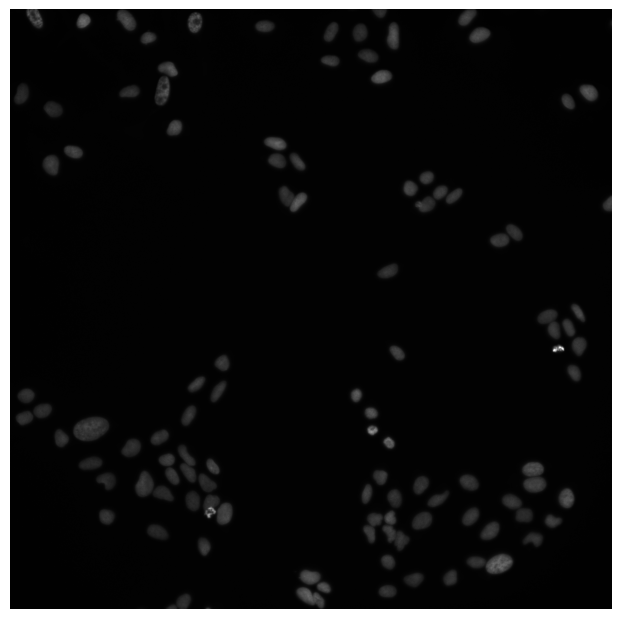

In [5]:
print(reader[0].shape)
img = reader[0][0] #displays image in the first channel (Hoechst)
imshow(img)

/Users/youmna/opt/anaconda3/envs/iaf-env/lib/python3.11/site-packages/iaf/plot/_plot.py:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


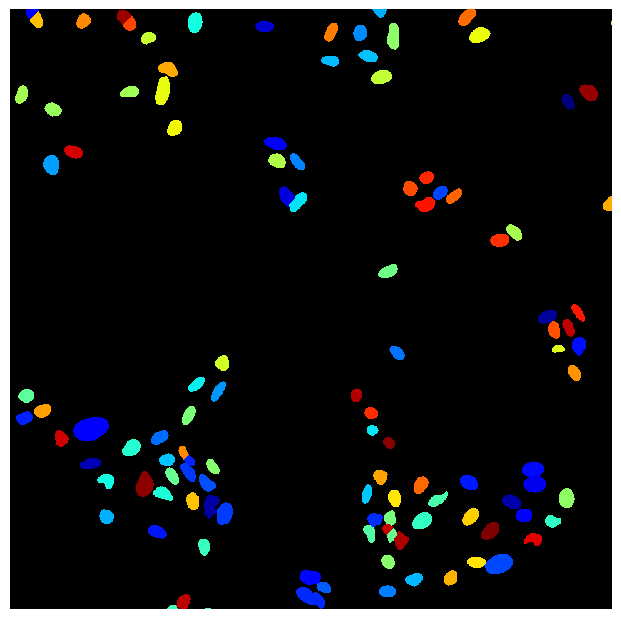

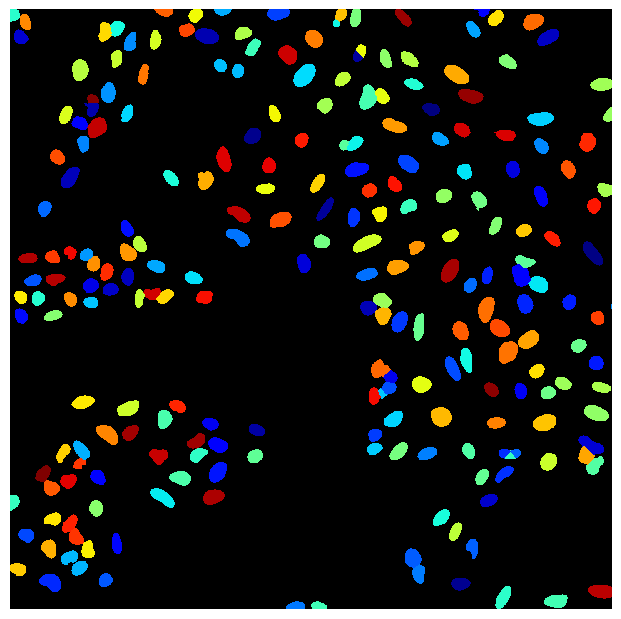

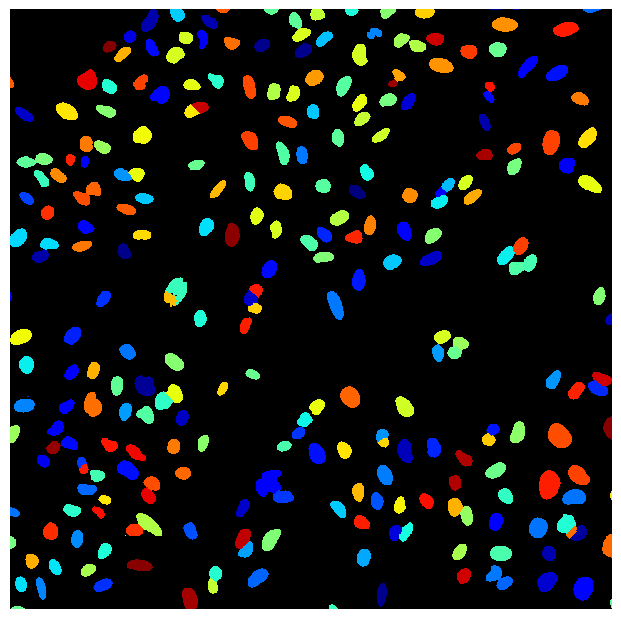

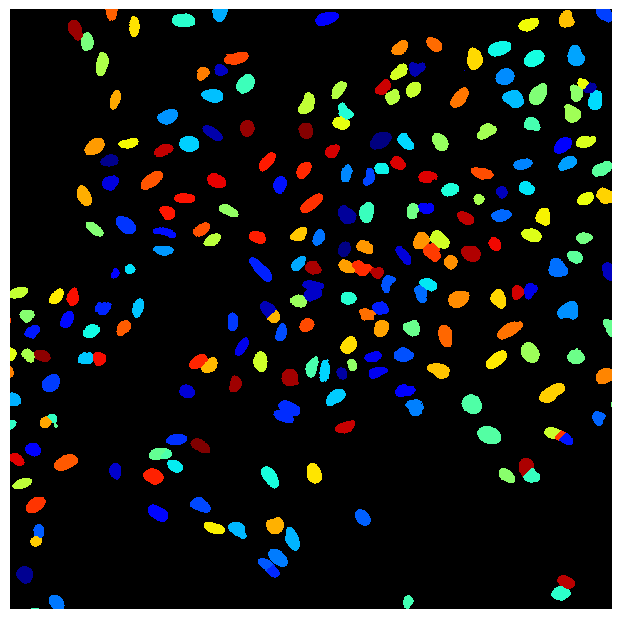

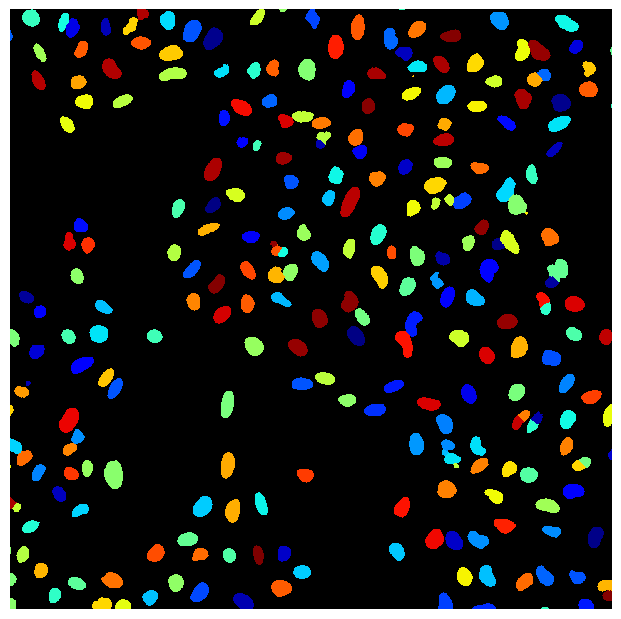

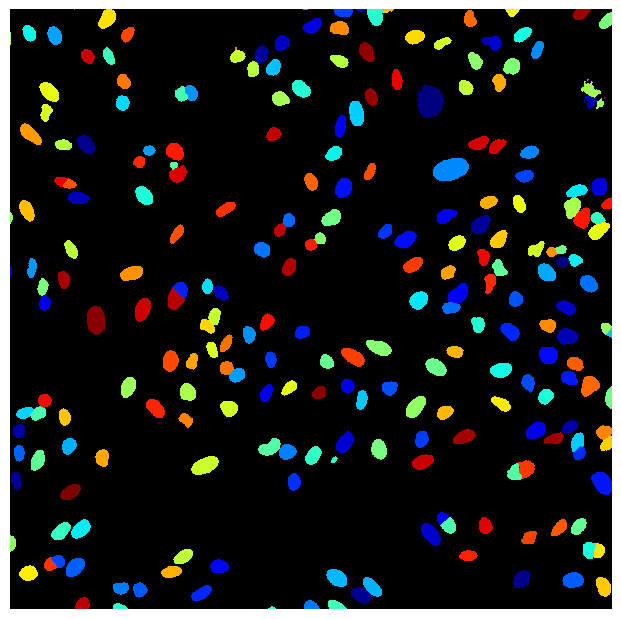

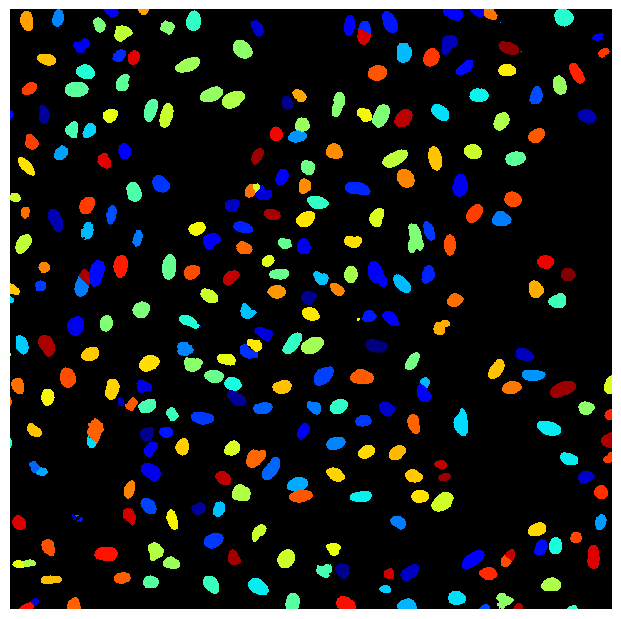

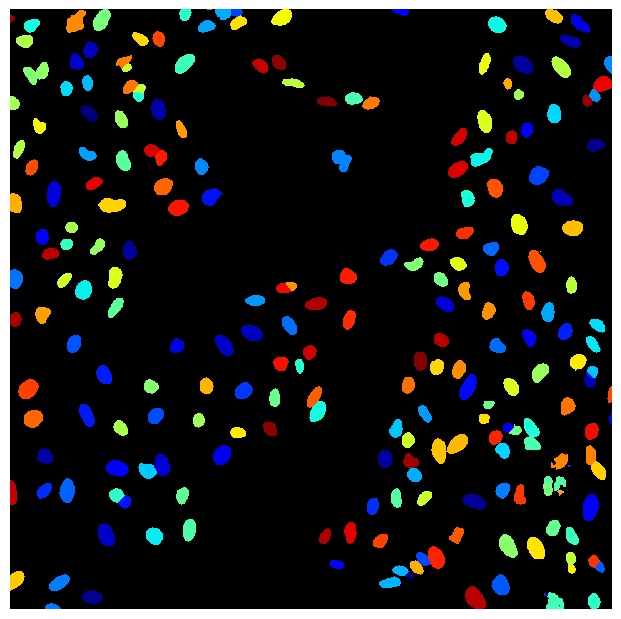

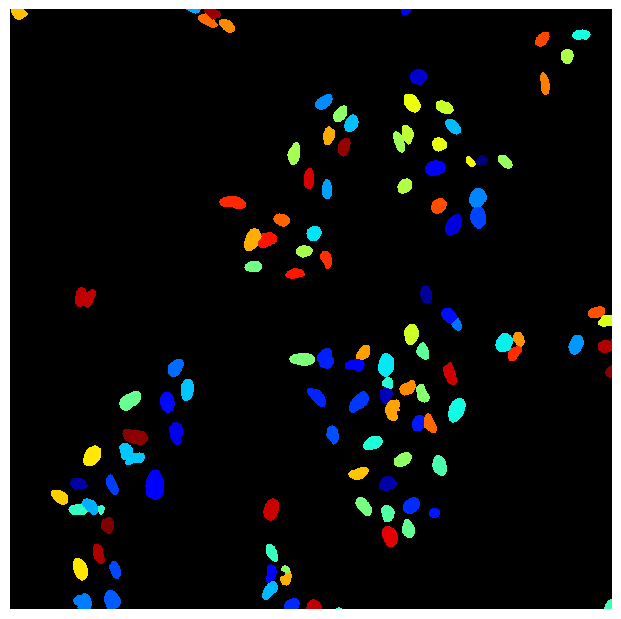

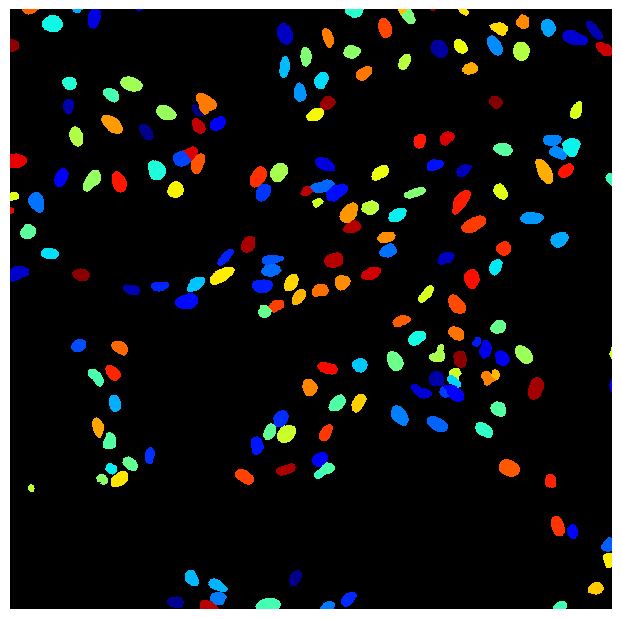

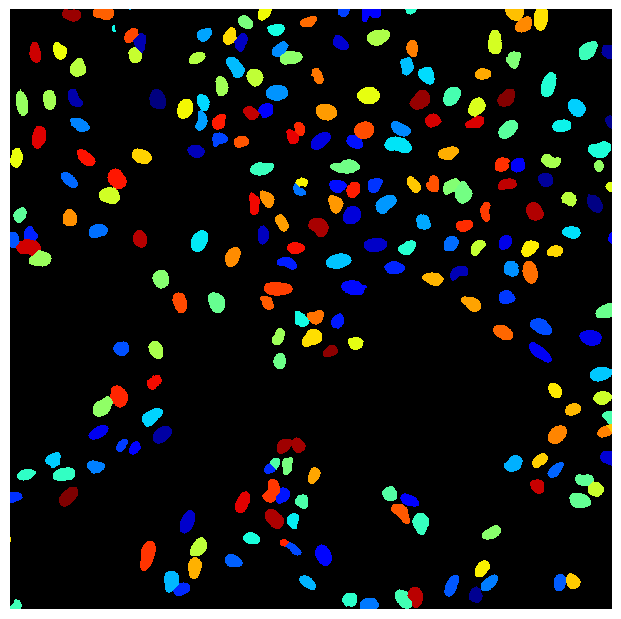

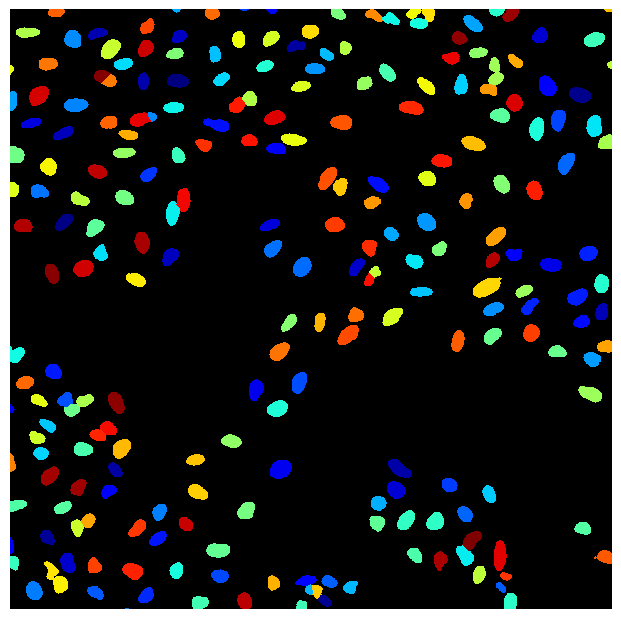

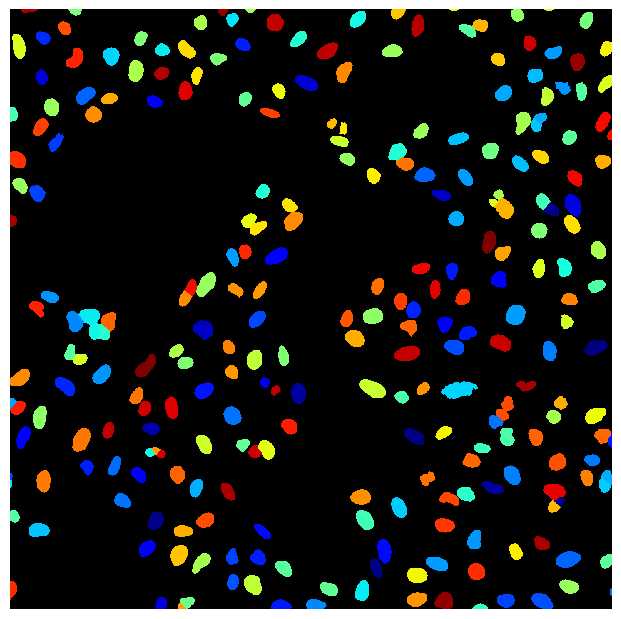

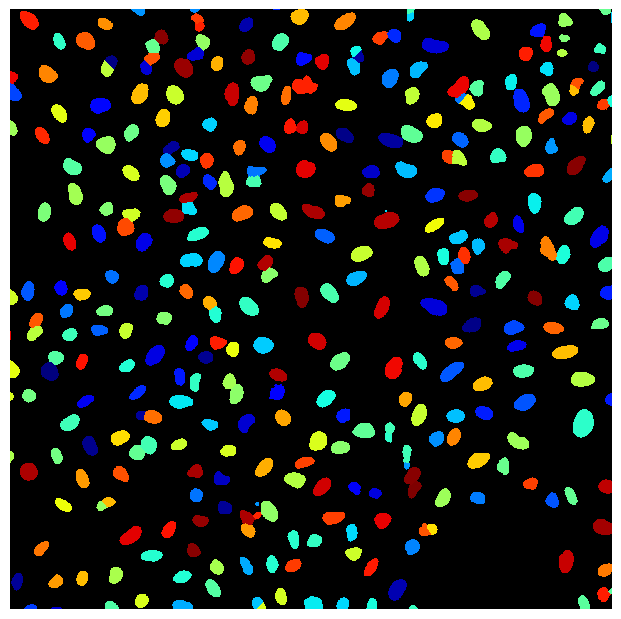

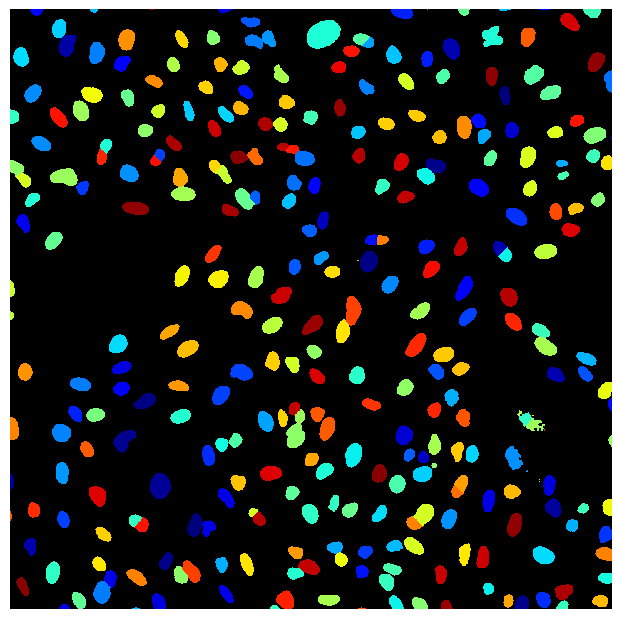

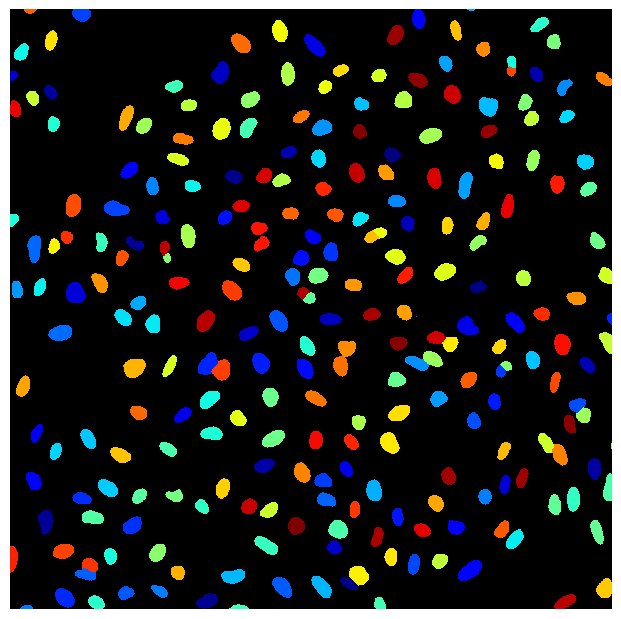

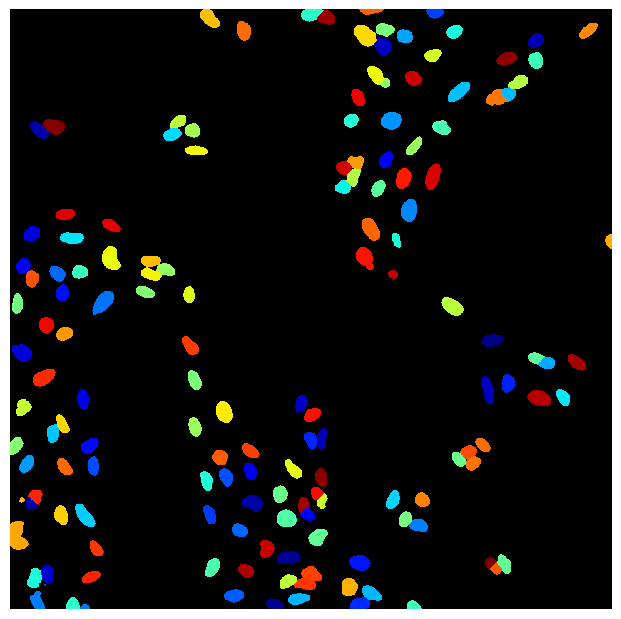

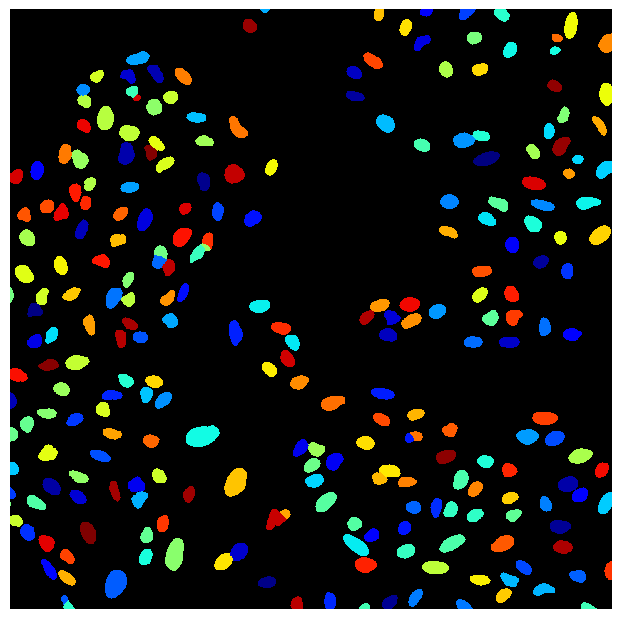

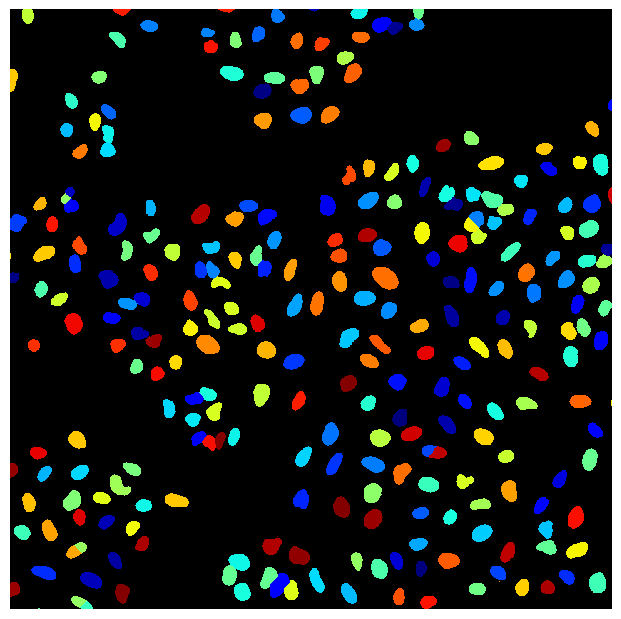

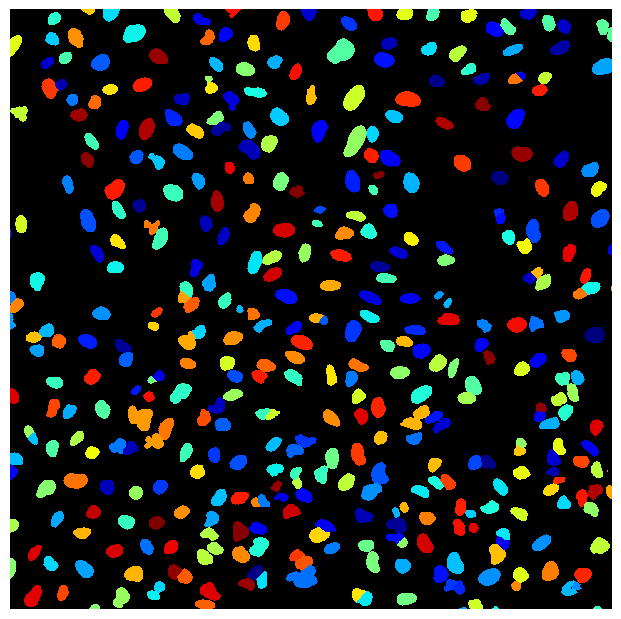

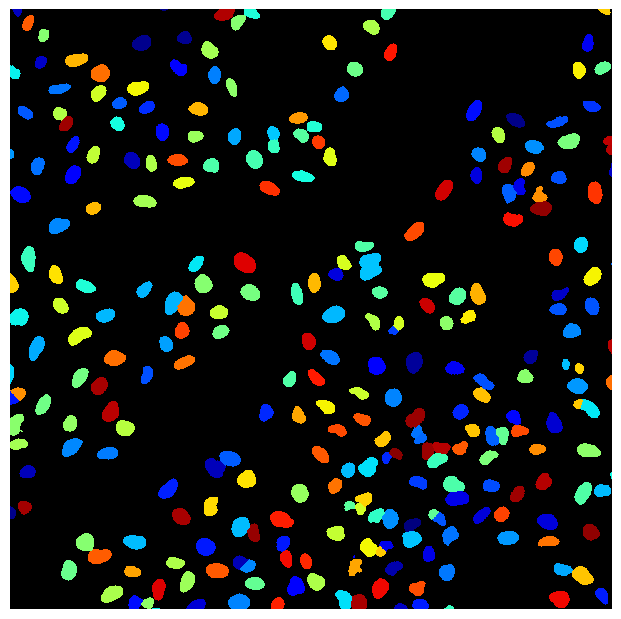

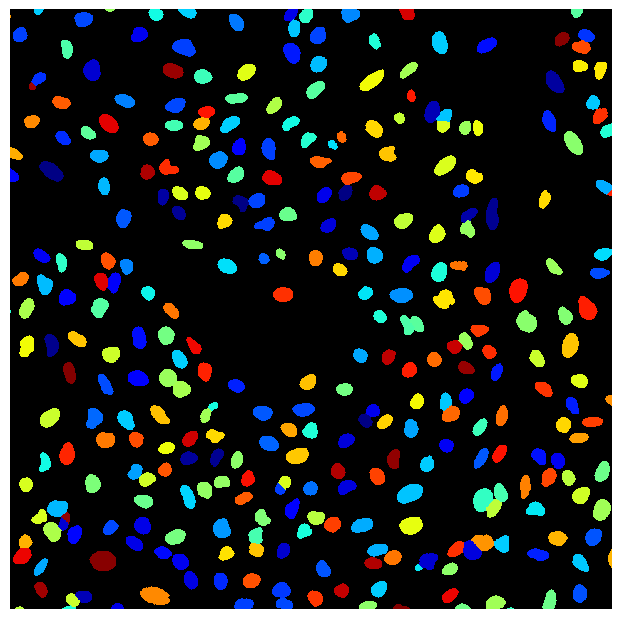

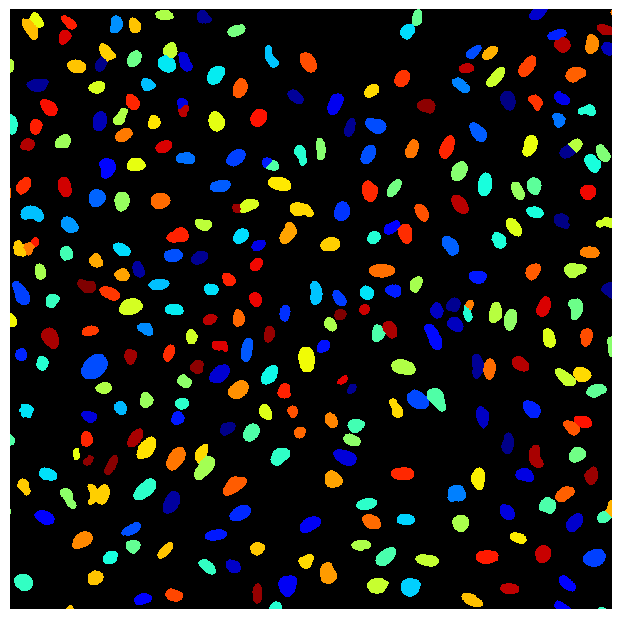

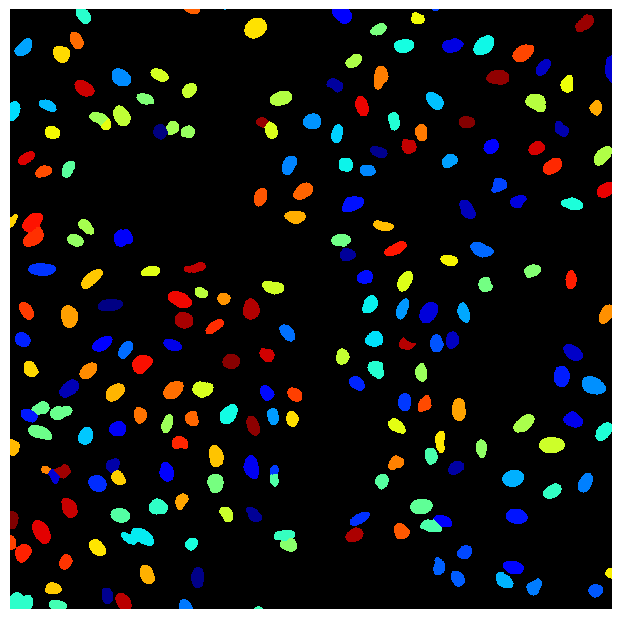

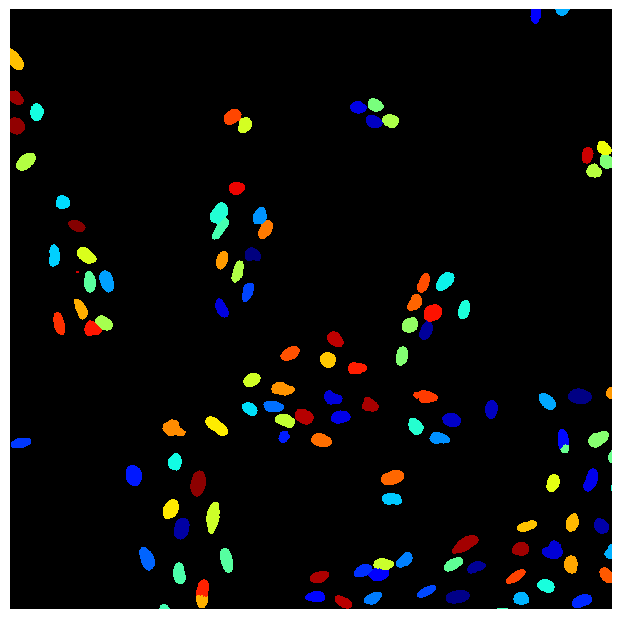

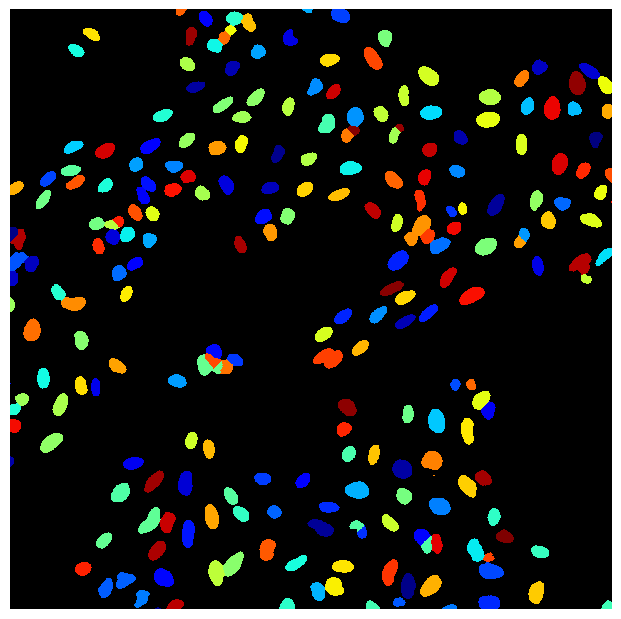

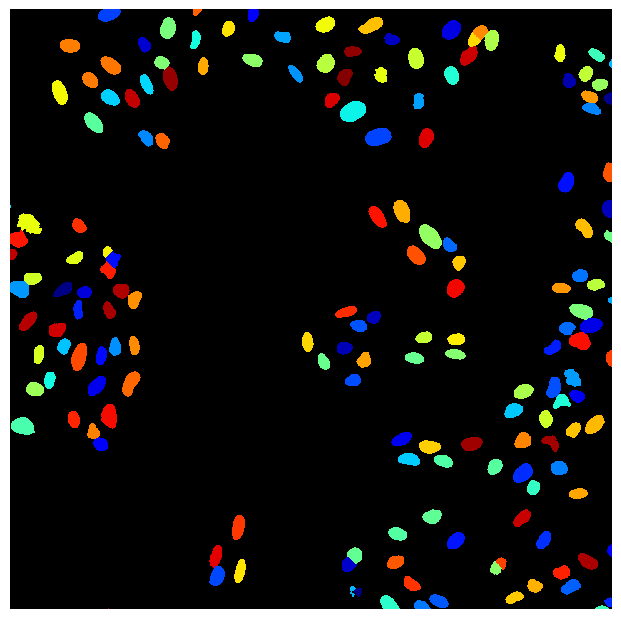

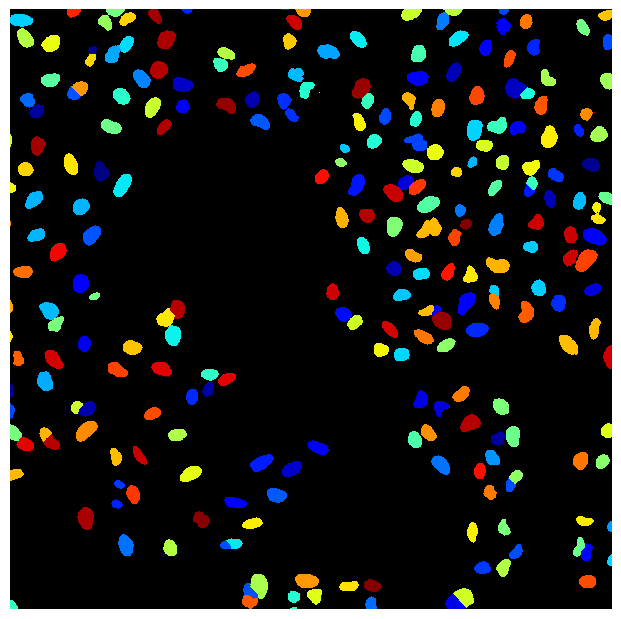

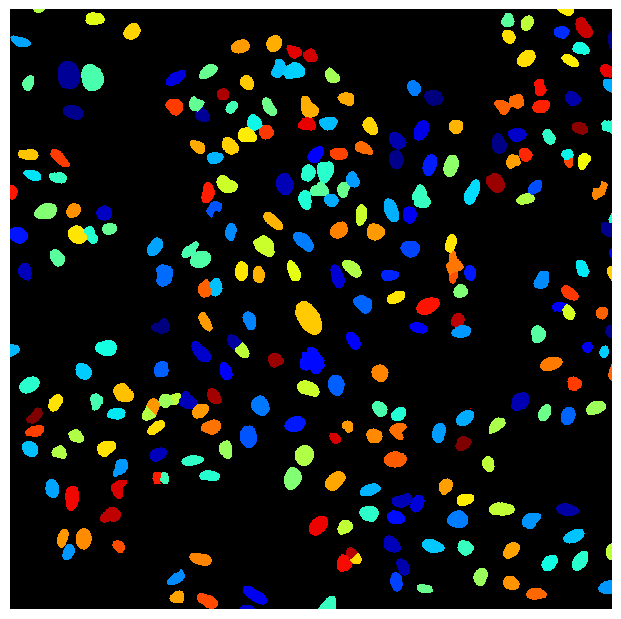

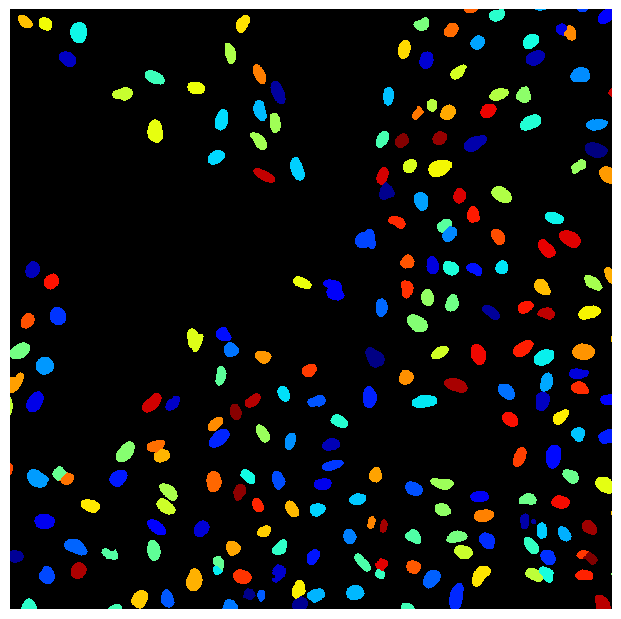

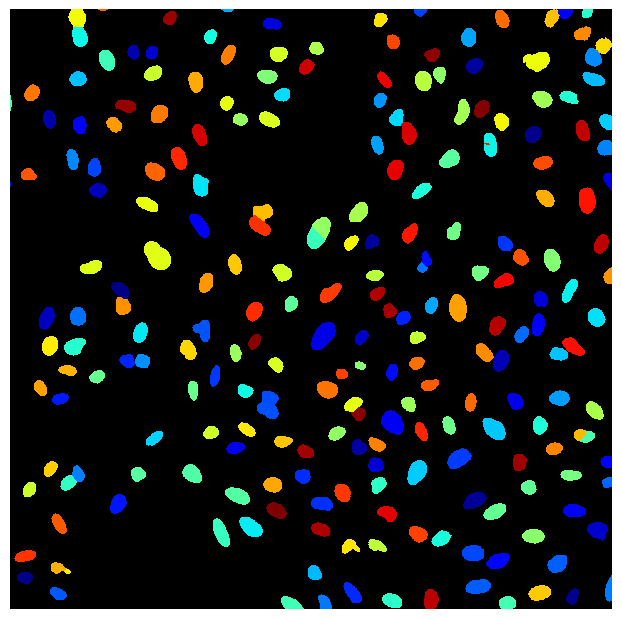

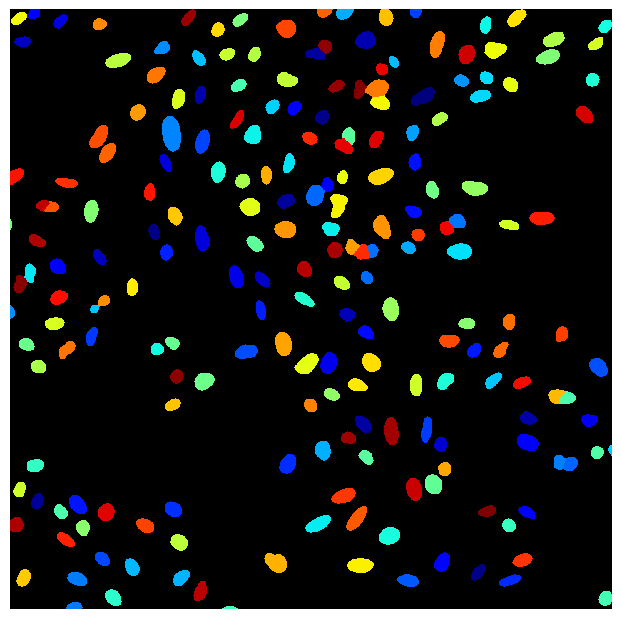

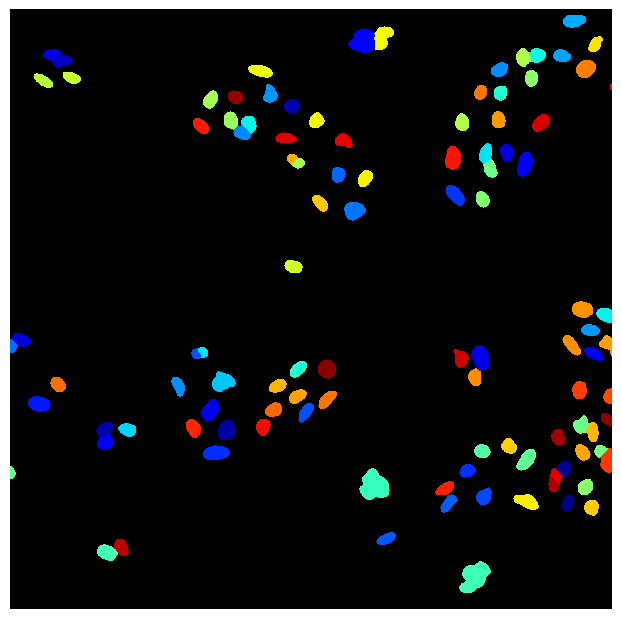

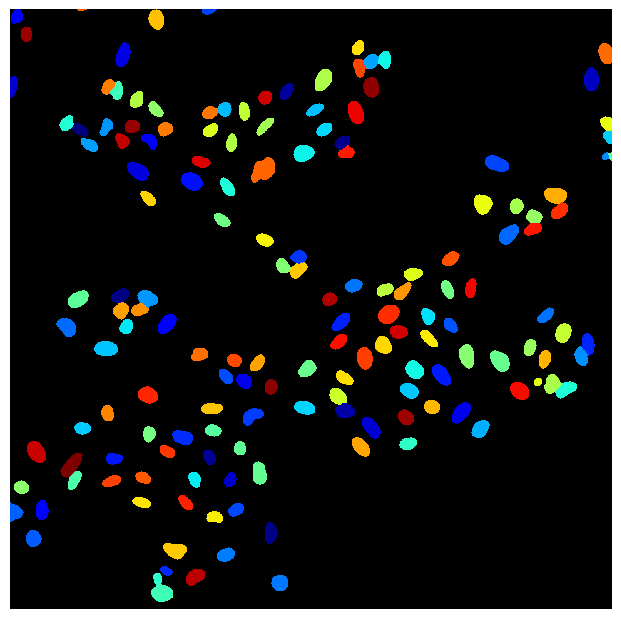

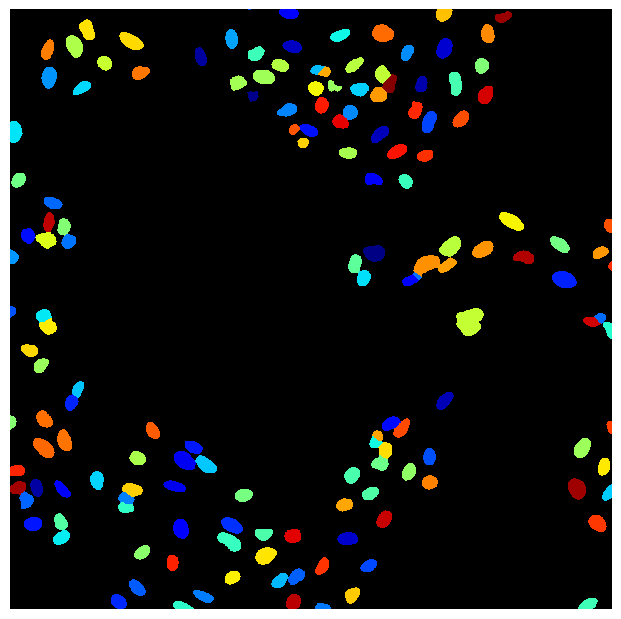

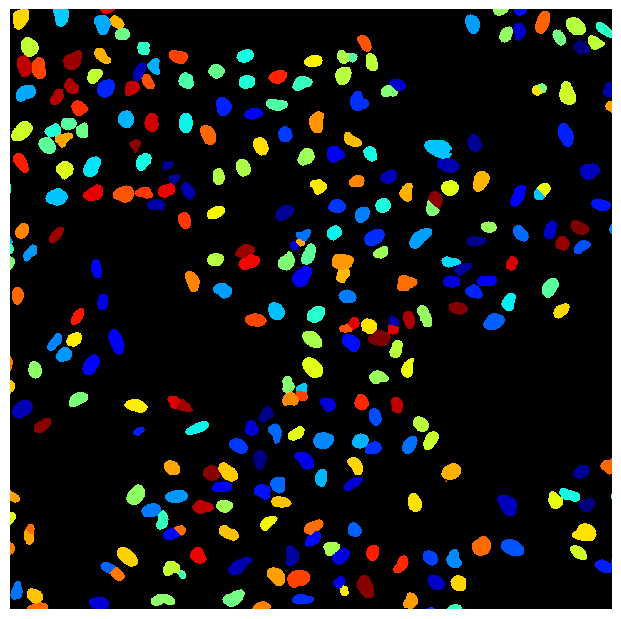

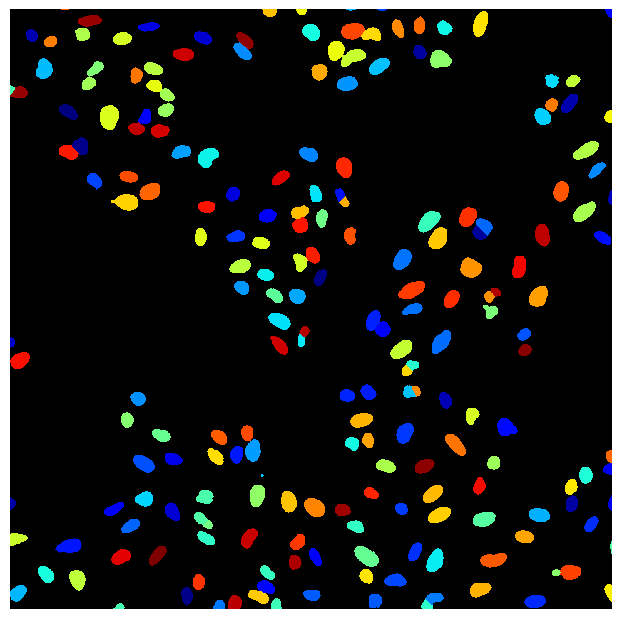

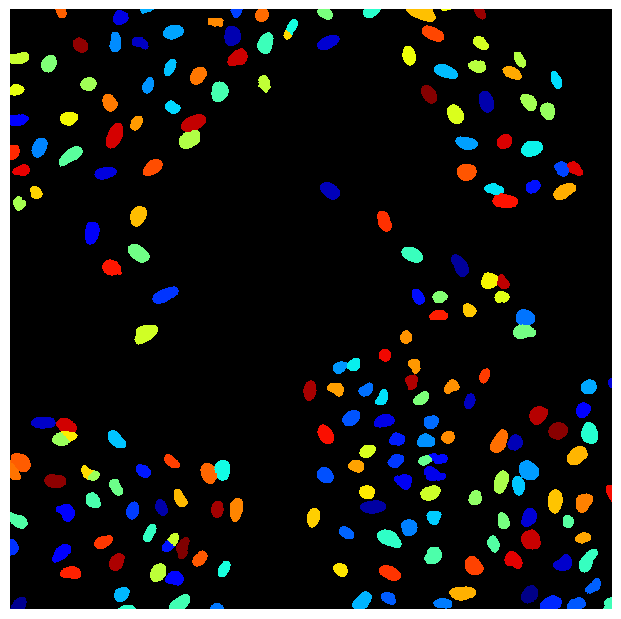

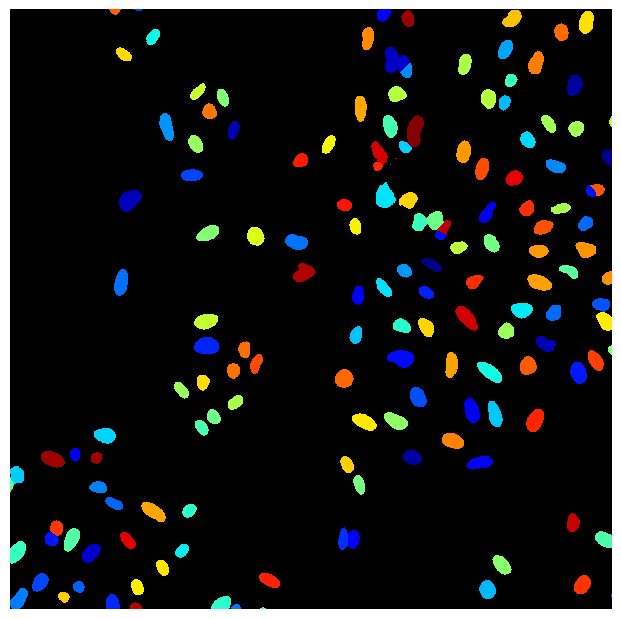

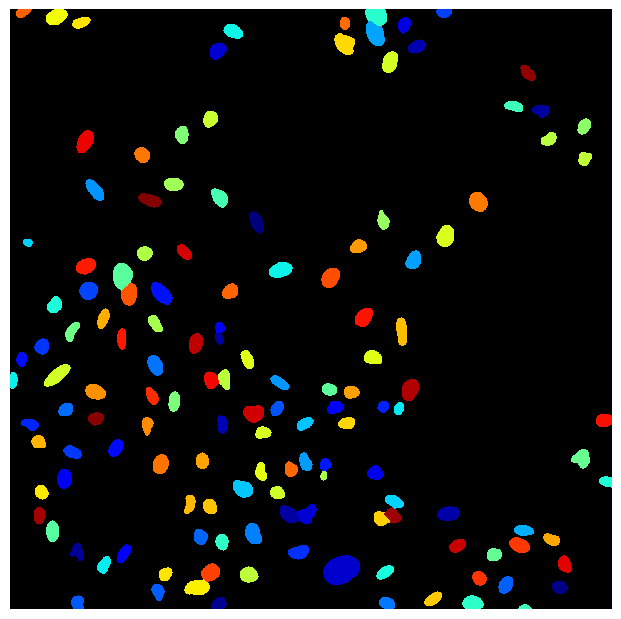

In [6]:
cell_num = []
results = []

for well_index in range(0, 40):
    frame = reader[well_index]
    
    # Segment nuclei from Hoechst channel
    hoechst_image = frame[0] # Assuming Hoechst is in channel 0
    img_gaussian = gaussian(hoechst_image, sigma=1.0) #Apply gaussian filter
    img_corr = subtract_background(img_gaussian, "morphological_opening", 100, 0, 4, False) #Substract background with morphological opening
    otsu_th = threshold_otsu(img_corr)
    binary_nuclei = img_corr > otsu_th
    labeled_nuclei, num_nuclei = label(binary_nuclei, background=0, return_num=True, connectivity=1)
    labels_sep , num_sep, _ = separate_neighboring_objects(binary_nuclei, labeled_nuclei)
    show_labels(labels_sep, plot_centroids=False)
    cell_num.append(num_sep)
    
    # Extract the mean Ki-67 signal for each nucleus
    ki67_image = frame[1] # Assuming Ki-67 is in channel 1
    
    # Apply background subtraction to the Ki-67 channel
    img_gaussian_ki67 = gaussian(ki67_image, sigma=1.0) 
    img_corr_ki67 = subtract_background(img_gaussian_ki67, "morphological_opening", 100, 0, 4, False) 
    
    mean_ki67_intensity = []
    for nucleus_label in range(1, num_nuclei +1):
        nucleus_mask = labeled_nuclei == nucleus_label
        mean_intensity = np.mean(img_corr_ki67[nucleus_mask])
        mean_ki67_intensity.append(mean_intensity)
    
    # Store results in a list
    results.extend([(well_index, nucleus, intensity) for nucleus, intensity in enumerate(mean_ki67_intensity, start=1)])
    
# Create a data frame with the results
df = pd.DataFrame(results, columns=["Well", "Nucleus", "Mean_Ki67_Intensity"])

# Save the DataFrame to a CSV file
df.to_csv("ki67_intensity_results_new.csv", index=False)